# 定性使用 BJT 三极管

陈硕 2024/05

In [1]:
%matplotlib inline
%load_ext tikzmagic

from math import exp, log, log10
import numpy as np
import scipy
from matplotlib import pyplot as plt
import ngspyce as ng

# kΩ μA

In [2]:
def para(r1, r2):
  return (r1*r2) / (r1 + r2)

def print_op(show_ib=True, show_ie=False):
  op = ng.operating_point()
  for k in sorted(op.keys()):
    if '[i' in k or '#branch' in k:
        if '[is]' in k:
            continue
        if '[ie]' in k and not show_ie:
            continue
        if '[ib]' in k and not show_ib:
            continue
        current = op[k][0]
        k = k.replace('q.x.', '')
        k = k.replace('r.x.', '')
        if abs(current) > 1e-3:
            print('%10s = %8.3f mA' % (k, 1e3*current))
        else:
            print('%10s = %8.3f uA' % (k, 1e6*current))
    elif '[g' in k:
        gm = op[k][0]
        if gm > 10e-3:
            print('%10s = %8.3f mS' % (k, 1e3 * gm))
        else:
            print('%10s = %8.3f uS' % (k, 1e6 * gm))
    else:  # Voltage
        voltage = op[k][0]
        k = k.replace('x.', '')
        if abs(voltage) > 10e-3:
            print('%10s = %8.4f V' % (k, voltage))
        else:
            print('%10s = %8.1f uV' % (k, 1e6*voltage))


BJT 大信号 Ebers-Moll 模型

放大区

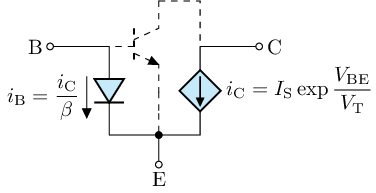

In [6]:
%%tikz -ct
\ctikzset{european voltages, american currents, european resistors}
\ctikzset{transistors/arrow pos=end, transistors/fill=cyan!20}
\ctikzset{diodes/fill=cyan!20, csources/fill=cyan!20}

\newcommand{\li}[1]{\ensuremath{i_\mathrm{#1}}}
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}
\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}

\draw [dashed] (0, 0) node [npn] (Q) {}; 
\draw (Q.B) to [D, bipoles/length=1cm] ++(0, -1.5) coordinate (E);
\draw (Q.B) to [short, -o] ++(-1, 0) node [left] {B};
\draw [dashed] (Q.E) to [short] (Q.E |- E); 
\draw (Q.E |- E) to [short, *-o] ++(0, -0.5) node [below] {E};
\draw (Q) ++(0.7, 0) coordinate (C) 
  to [american controlled current source, l={$\li{C}=\ui{S}\exp\displaystyle\frac{\uv{BE}}{\uv{T}}$}, bipoles/length=1cm] (C|-E)
  -- (E);
\draw (C) to [short, -o] ++(1, 0) node [right] {C};
\draw [dashed] (Q.C) -| (C);
\draw (Q.B)++(-0.1,0) to [open, f_={$\li{B}=\displaystyle\frac{\li{C}}{\beta}$}] ++(0, -1);


三极管的定性使用：$\newcommand{\li}[1]{{i_\mathrm{#1}}}$
$\newcommand{\ui}[1]{{I_\mathrm{#1}}}$
$\newcommand{\lv}[1]{{v_\mathrm{#1}}}$
$\newcommand{\uv}[1]{{V_\mathrm{#1}}}$
$\newcommand{\sm}[2]{{{#1}_\mathrm{#2}}}$

* $\uv{BE}\approx 0.7$V，因 $V_\mathrm{BE}$ 略微增加时，$I_\mathrm{C}$ 显著增大。
* $\ui{E}\approx \ui{C}$，因 $\beta\gg 1$
* 无须针对不同的 $\beta$ 调整。

放大区

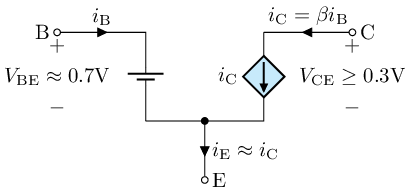

In [21]:
%%tikz -ct
\ctikzset{american voltages, american currents, european resistors}
\ctikzset{transistors/arrow pos=end, transistors/fill=cyan!20}
\ctikzset{diodes/fill=cyan!20, csources/fill=cyan!20}

\newcommand{\li}[1]{\ensuremath{i_\mathrm{#1}}}
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}
\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}

\draw (0, 0) node [left] {B}
  to [short, o-, i={\li{B}}] ++(1.5, 0) coordinate (B)
  to [battery1, bipoles/length=1cm] ++(0, -1.5) coordinate (E);
\draw (0, 0) to [open,v={$\uv{BE}\approx 0.7\mathrm{V}$}] ++(0, -1.5);

\draw (B) ++(2, 0) coordinate (C)
  to [american controlled current source, l_={$\li{C}$}, bipoles/length=1cm] (C|-E)
  -- (E);
\draw (C) to [short, -o, i<={$\li{C}=\beta \li{B}$}] ++(1.5, 0)
  node [right] {C}
  to [open, v={$\uv{CE}\ge 0.3\mathrm{V}$}] ++(0, -1.5);
\draw (E) ++(1, 0) to [short, *-o, i={$\li{E}\approx\li{C}$}] ++(0, -1) node [right] {E};

## 射极跟随器 emitter follower

简称“射随器/follower”，主要起一个电压跟随的作用。

要定量，用运放。

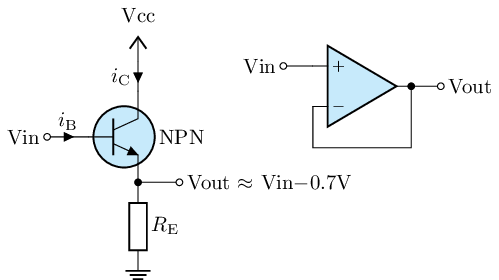

In [69]:
%%tikz -ct
\ctikzset{european resistors, transistors/arrow pos=end, transistors/fill=cyan!20, amplifiers/fill=cyan!20}
\newcommand{\li}[1]{\ensuremath{i_\mathrm{#1}}}
\draw (0, 0) node [left] {Vin}
to [short, o-, i=$\li{B}$] ++(0.7, 0)
node [npn, tr circle, anchor=B] (Q) {NPN};
\draw (Q.C) to [short,i^<=$\li{C}$] ++(0, 0.5) node [vcc] {Vcc};
\draw (Q.E)
to [R, l=$R_\mathrm{E}$, bipoles/length=1cm] ++(0, -1.5) node [tlground] {};
\draw (Q.E) to [short, *-o] ++(0.7, 0) node [right] {Vout $\approx$ Vin$-$0.7V};

\draw (4, 1.2) node [left] {Vin}
to [short, o-] ++(0.5, 0)
node [scale=0.7, op amp, anchor=+, noinv input up] (OA) {};
\draw (OA.-) to [short] ++(0, -0.7) -| (OA.out);
\draw (OA.out) to [short, *-o] ++(0.5, 0) node [right] {Vout};

定性分析：

Emitter follower 的主要功能是阻抗变换，相当于把负载电阻 $\sm{R}{E}$ 的阻值放大了 $\beta + 1$ 倍。


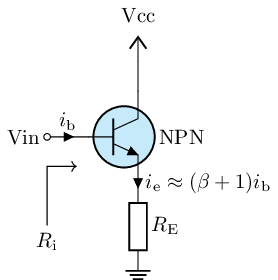

In [6]:
%%tikz -ct -p amsmath
\ctikzset{european resistors, transistors/arrow pos=end, transistors/fill=cyan!20, amplifiers/fill=cyan!20}
\newcommand{\li}[1]{\ensuremath{i_\mathrm{#1}}}
\newcommand{\uv}[1]{{V_\mathrm{#1}}}
\newcommand{\sm}[2]{{{#1}_\mathrm{#2}}}

\draw (0, 0) node [left] {Vin}
to [short, o-, i=$\li{b}$] ++(0.7, 0)
node [npn, tr circle, anchor=B] (Q) {NPN};
\draw (Q.C) to [short] ++(0, 0.5) node [vcc] {Vcc};
\draw (Q.E)
to [R, l=$R_\mathrm{E}$, bipoles/length=1cm] ++(0, -1.5) node [tlground] {};
\draw (Q.E) node [currarrow, rotate=-90] {} node [right] {$\li{e}=(\beta+1)\li{b}$};

\draw [->] (0, -1.5) node [below] {$R_\mathrm{i}$} to ++(0, 1) to ++(0.5, 0);

假设负载电阻 $\sm{R}{E}=1$kΩ，如果 $\uv{E}=1$V，那么 $\ui{E}=1$mA。直接驱动需要 1mA 电流，但是通过 emitter follower，借助三极管的电流放大作用（假设 $\beta=100$），输入端只需要提供 $\dfrac{\ui{E}}{1+\beta}\approx 10$μA电流就能驱动电阻 $\sm{R}{E}$，相当于驱动一个 100kΩ 的电阻。

如果要求 $\uv{E}=10$V，那么 $\ui{E}=10$mA。直接驱动需要 10mA 电流。通过 emitter follower，输入端只需要提供 $\dfrac{\ui{E}}{1+\beta}\approx 100$μA电流就能驱动电阻 $\sm{R}{E}$，还是相当于驱动一个 100kΩ 的电阻。

这其实正是晶体管(transistor)的本意：transistor = transfer + resistor，“传阻/跨阻 transresistance”器件。把输出端的电阻 $\sm{R}{E}$ 变换到输入端，变换的比例是 $\beta+1$，相当于把 $\sm{R}{E}$ 的阻值放大了 $\beta + 1$ 倍。这里把 1kΩ 的电阻变为了约 100kΩ 的电阻，驱动起来就容易得多了。（这里只作定性处理，暂时忽略 $r_\pi$ 和 $\sm{r}{o}$）

In [4]:
ng.circ("""
  Vcc Vcc 0 10V
  Vin b 0 DC 5V SINE(5 3 1k)
  Q Vcc b e NPN
  Re e 0 1000
  .model NPN NPN(IS=5fA BF=200 VAF=140)
  .options savecurrents
  """)
print_op()

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


    @q[ib] =   20.612 uA
    @q[ic] =    4.270 mA
    @re[i] =    4.290 mA
         b =   5.0000 V
         e =   4.2903 V
       vcc =  10.0000 V
vcc#branch =   -4.270 mA
vin#branch =  -20.612 uA


ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


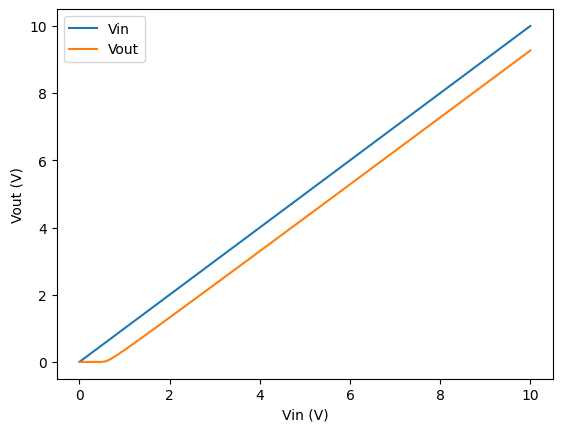

In [44]:
ng.cmd('dc vin 0 10 0.1')
Ic = -1000 * ng.vectors()['vcc#branch']
Ve = ng.vectors()['e']
Vin = ng.vectors()['b']
plt.plot(Vin, Vin, label='Vin')
plt.plot(Vin, Ve, label='Vout')
plt.xlabel("Vin (V)")
plt.ylabel("Vout (V)")
plt.legend()

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


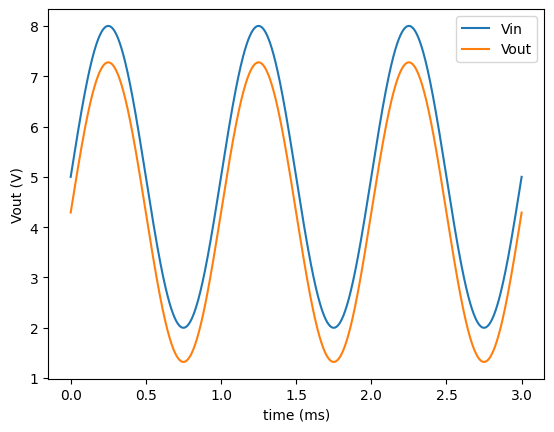

In [41]:
ng.cmd('tran 1u 3m')
Ic = -1000 * ng.vectors()['vcc#branch']
Ve = ng.vectors()['e']
Vin = ng.vectors()['b']
time = ng.vectors()['time'] * 1e3
plt.plot(time, Vin, label='Vin')
plt.plot(time, Ve, label='Vout')
plt.xlabel("time (ms)")
plt.ylabel("Vout (V)")
plt.legend()

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


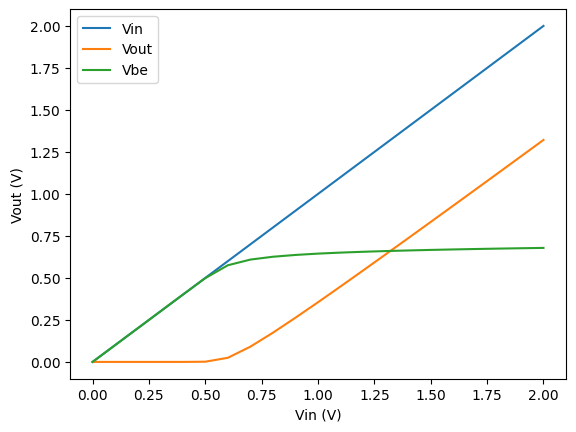

In [46]:
ng.cmd('dc vin 0 2 0.1')
Ic = -1000 * ng.vectors()['vcc#branch']
Ve = ng.vectors()['e']
Vin = ng.vectors()['b']
plt.plot(Vin, Vin, label='Vin')
plt.plot(Vin, Ve, label='Vout')
plt.plot(Vin, Vin-Ve, label='Vbe')
plt.xlabel("Vin (V)")
plt.ylabel("Vout (V)")
plt.legend()

### Linear regulator

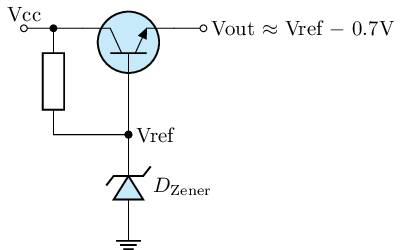

In [11]:
%%tikz -ct

\ctikzset{american voltages, american currents, european resistors}
\ctikzset{diodes/fill=cyan!20, transistors/arrow pos=end, transistors/fill=cyan!20, amplifiers/fill=cyan!20}
\draw (0, 0) node [above] {Vcc}
  to [short, o-*] ++(0.5, 0) coordinate (IN)
  to [short] ++(0.5, 0)
  node [npn, tr circle, rotate=90, anchor=C] (Q1) {}; 
% \ctikzset{bipoles/length=1cm};
\draw (IN) to [R, bipoles/length=1.2cm] ++(0, -1.8) coordinate (RC)
  to [short, -*] (RC-|Q1.B) to [short] (Q1.B);
\draw (RC -| Q1.B) node [circ] {} node [right] {Vref}
  to [zzD, invert, mirror, l={$D_\mathrm{Zener}$}, n=DZ, bipoles/length=1.0cm] ++(0, -1.8)
  node [tlground] {}; 
\draw (Q1.E) to [short, -o] ++(0.5, 0) node [right] {Vout $\approx$ Vref $-$ 0.7V};

In [11]:
ng.circ("""
  Vcc  Vcc 0     10V
  Vref b   0     5.7V
  Q    Vcc b  e  NPN
  Re   e   0     1000
  .model NPN NPN(IS=5fA BF=200 VAF=140)
  .options savecurrents
  """)
print_op()

    @q[ib] =   24.072 uA
    @q[ic] =    4.962 mA
    @re[i] =    4.986 mA
         b =   5.7000 V
         e =   4.9863 V
       vcc =  10.0000 V
vcc#branch =   -4.962 mA
vref#branch =  -24.072 uA


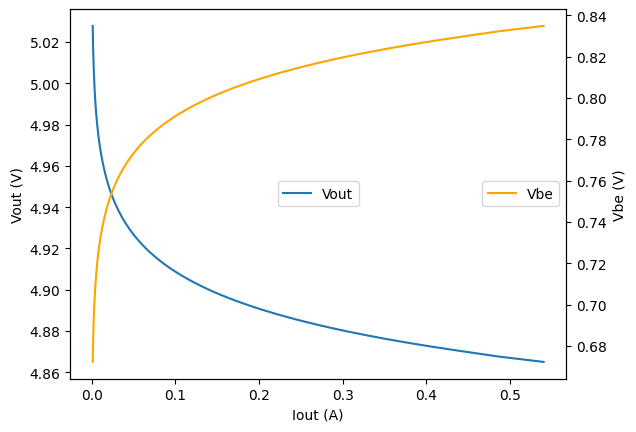

In [23]:
ng.cmd('dc re 9 5000 1')
Re = ng.vector('res-sweep')
Vout = ng.vector('e')
fig,ax = plt.subplots()
plt.plot(Vout/Re, Vout, label='Vout')
plt.xlabel('Iout (A)')
plt.ylabel('Vout (V)')
plt.legend(loc='center')
ax2 = ax.twinx()
plt.plot(Vout/Re, 5.7 - Vout, 'orange', label='Vbe')
plt.ylabel('Vbe (V)')
plt.legend(loc='right')

### 截止区 cut-off region

BE 结是单向导通，所以当 Vb < Ve 时，三极管会截止。

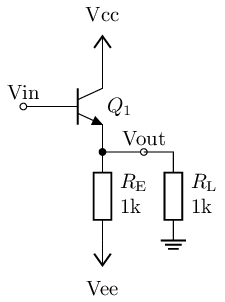

In [50]:
%%tikz -ct

\ctikzset{european resistors, transistors/arrow pos=end}
\draw (0, 0) node [above] {Vin}
  to [short, o-] ++(0.5, 0)
  node [npn, anchor=B] (Q1) {$Q_1$};
\draw (Q1.C) node [vcc] {Vcc};
\draw (Q1.E) to [short, *-o] ++(0.7, 0) coordinate (OUT)
  node [above] {Vout};
\draw (Q1.E) to [R, l2={$R_\mathrm{E}$ and 1k}, *-, bipoles/length=1cm] ++(0, -1.5) coordinate (VEE)
  node [vee] {Vee};
\draw (OUT) to [short] ++(0.5, 0)
  to [R, l2={$R_\mathrm{L}$ and 1k}, bipoles/length=1cm] ++(0, -1.5) coordinate (G)
  node [tlground] {};

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


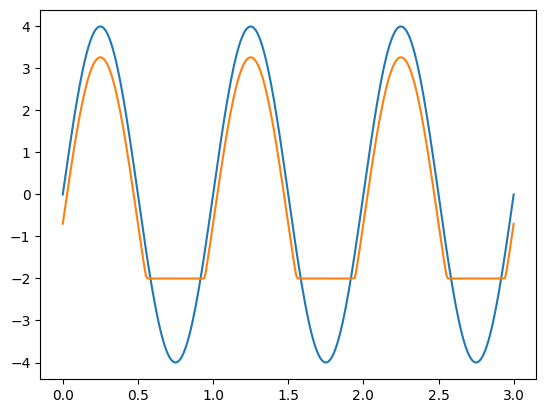

In [49]:
ng.circ("""
  Vcc Vcc 0    4V
  Vee 0   Vee  4V
  Vin b   0    DC 0V SINE(0, 4, 1k)
  Q1  Vcc b    e  NPN
  Re  e   Vee  1000
  Rl  e   0    1000
  .model NPN NPN (IS=5fA BF=200 VAF=130)
  """)

ng.cmd('tran 10u 3m')
Vin = ng.vectors()['b']
Vout = ng.vectors()['e']
time = ng.vector('time')*1000
plt.plot(time, Vin, label='Vin')
plt.plot(time, Vout, label='Vout')

解决办法：有源负载

### BE 结击穿

小信号 BJT 的 BE 节击穿电压 $\uv{EBO}$ 大约是 6～7 V，但是 SPICE 的 BJT 模型没有对此建模。

### Vbe 抵消

可以看成 NPN 射随器和 PNP 射随器的前后配对使用，利用 NPN 和 PNP 的极性相反，将 Vbe 抵消。

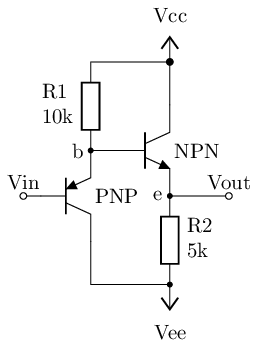

In [53]:
%%tikz -ct
\ctikzset{european resistors, transistors/arrow pos=end}
\draw (0, 0) node [above] {Vin}
  to [short, o-] ++(0.3, 0)
  node [pnp, anchor=B] (Q1) {PNP};
\draw (Q1.E) node [left] {b} to [short] ++(0.5, 0)
  node [npn, anchor=B] (Q2) {NPN};
\draw (Q1.E) to [R, l2={R1 and 10k}, *-, bipoles/length=1cm] ++(0, 1.5) coordinate (VCC)
  to (VCC-|Q2.C) node [vcc] {Vcc}
    to [short, *-] (Q2.C);
\draw (Q2.E) node [left] {e}
  to [R, l2={R2 and 1k}, *-*, bipoles/length=1cm] ++(0, -1.5) coordinate (VEE)
  node [vee] {Vee}
  to (VEE-|Q1.C) to [short] (Q1.C);
\draw (Q2.E) to [short, -o] ++(1.0, 0) node [above] {Vout};

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver
ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


         b =   5.6719 V
         e =   4.9584 V
 v1#branch =   -5.367 mA
       vcc =  10.0000 V
       vin =   5.0000 V
vin#branch =    2.550 uA


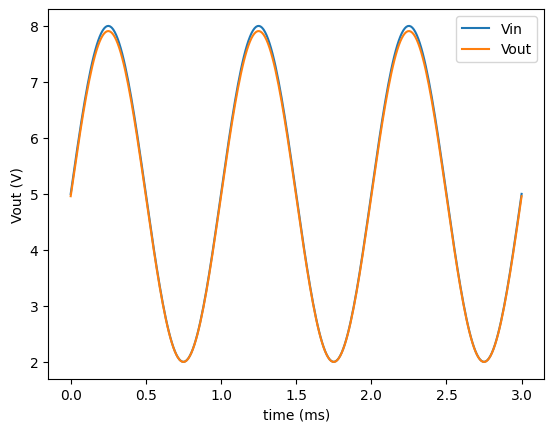

In [5]:
ng.circ("""
  V1 vcc 0      10V
  Q1 0   vin b  PNP
  Q2 vcc b   e  NPN
  R1 vcc b      10k
  R2 e   0      1k
  Vin vin 0 DC 5 SINE(5 3 1k)
  .model NPN NPN (IS=5fA BF=200 VAF=130)
  .model PNP PNP (IS=2fA BF=150 VAF=80)
  """)
print_op()
ng.cmd('tran 10u 3m')
Vin = ng.vectors()['vin']
Vb = ng.vectors()['b']
Vout = ng.vectors()['e']
time = ng.vector('time')*1000
plt.plot(time, Vin, label='Vin')
#plt.plot(time, Vb, label='Vb')
plt.plot(time, Vout, label='Vout')
plt.ylabel('Vout (V)')
plt.xlabel('time (ms)')
plt.legend()

Text(0, 0.5, 'Vout - Vin (mV)')

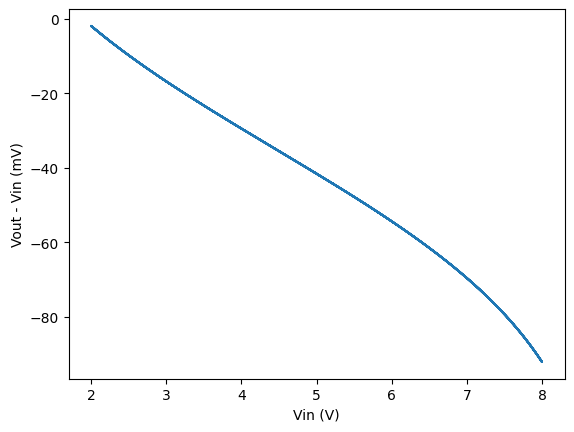

In [58]:
plt.plot(Vin, 1e3*(Vout-Vin))
plt.xlabel('Vin (V)')
plt.ylabel('Vout - Vin (mV)')

### 推挽输出 push-pull

可以看成 NPN 射随器和 PNP 射随器的上下配对使用。

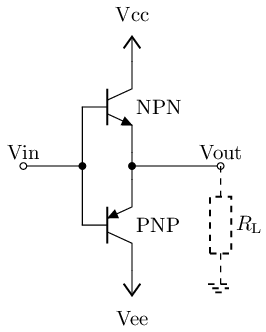

In [61]:
%%tikz -ct

\ctikzset{european resistors, transistors/arrow pos=end}
\draw (0, 0) node [above] {Vin}
  to [short, o-*] ++(1, 0) coordinate (IN);
\draw (IN) to [short] ++(0, 1)
  node[npn, anchor=B] (Q1){NPN};
\draw (IN) to [short] ++(0, -1)
  node[pnp, anchor=B] (Q2){PNP};
\draw (Q1.E) -- (Q2.E);
\draw (Q1.C) node[vcc]{Vcc};
\draw (Q2.C) node[vee]{Vee};
\draw (Q1.C|-IN) to [short, *-o] ++(1.5, 0) coordinate (OUT)
  node [above] {Vout};
\draw [dashed] (OUT) to [R, l=$R_\mathrm{L}$, bipoles/length=1.2cm] ++(0, -2) node [tlground] {};

{'vcc#branch': array([-1.00040769e-11]), 'vee#branch': array([-5.0105e-12]), 'vin#branch': array([-2.99999944e-15]), 'e': array([-3.42307629e-13]), 'b': array([0.]), 'vee': array([-5.]), 'vcc': array([5.])}


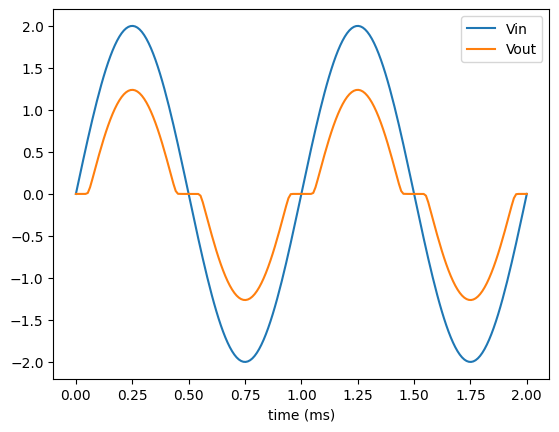

In [26]:
ng.circ("""
  Vcc Vcc 0 5V
  Vee 0 Vee 5V
  Vin b 0 DC 0V SINE(0, 2, 1k)
  Q1 Vcc b e NPN
  Q2 Vee b e PNP
  R1 e 0 100
  .model NPN NPN(IS=2fA BF=200 VAF=130)
  .model PNP PNP(IS=5fA BF=80  VAF=50)
  """)
ng.cmd('op')
print(ng.vectors())
ng.cmd('tran 10u 2m')
Vin = ng.vectors()['b']
Vout = ng.vectors()['e']
time = ng.vector('time')*1000
plt.plot(time, Vin, label='Vin')
plt.plot(time, Vout, label='Vout')
plt.xlabel('time (ms)')
plt.legend()

### 定量分析与 Sziklai Pair

输入阻抗：前面我们分析过，从输入端看进去，emitter follower 相当于把射级负载电阻 $\sm{R}{E}$ 放大了 $\beta + 1$ 倍，再加上三极管本身的输入阻抗 $r_\pi$，整个电路的输入阻抗 $\sm{R}{i}=r_\pi+(1+\beta)\sm{R}{E}$，其中 $r_\pi=\dfrac{\beta}{\sm{g}{m}}=\dfrac{\beta\uv{T}}{\ui{C}}$。如果 $\ui{C}=1$mA，那么 $\sm{g}{m}=\dfrac{\ui{C}}{\uv{T}}=\dfrac{1\mathrm{mA}}{26\mathrm{mV}}=\dfrac{1}{26\Omega}\approx38.5$mS。如果 $\beta=100$，$r_\pi=\dfrac{\beta}{\sm{g}{m}}=100\times 26=2600\Omega$，跟 $\sm{R}{i}$ 的第二项 $(1+\beta)\sm{R}{E}$ 比起来，$r_\pi$ 通常可忽略不计。


输出阻抗：

易见输出电流为 $\li{E}$。

假设输入电压不变，输出电流从 1mA 变化为 10mA，那么输出电压会略微降低 60mV，因为 $\uv{T}\ln 10\approx 26\times 2.3\approx 60$mV.
那么它的输出阻抗 $\sm{R}{o}=\dfrac{\Delta \uv{out}}{\Delta \ui{out}} = \dfrac{60}{9}=6.67$Ω.

假设输出电流从 10mA 增加到 100mA，那么输出电压会继续降低 60mV，这时它的输出阻抗变为 $\sm{R}{o}=\dfrac{\Delta \uv{out}}{\Delta \ui{out}} = \dfrac{60}{90}=0.667$Ω.

可以看出，射极跟随器的输出阻抗与它当前的 $\ui{E}$ 有关，一般教科书用 $\sm{r}{e}$ 表示，$\sm{r}{e}=\dfrac{\uv{T}}{\ui{E}}\approx \dfrac{1}{\sm{g}{m}}$。这个电阻通常较小，在欧姆级别。

由于 $\sm{r}{e} >0$，所以电压增益 $\sm{A}{v} < 1$。通常 $\sm{R}{E}\gg\sm{r}{e}$，那么 $\sm{A}{v} \approx 1$.


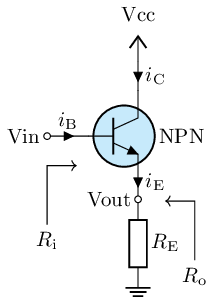

In [3]:
%%tikz -ct
\ctikzset{european resistors, transistors/arrow pos=end, transistors/fill=cyan!20, amplifiers/fill=cyan!20}
\newcommand{\li}[1]{\ensuremath{i_\mathrm{#1}}}
    
\draw (0, 0) node [left] {Vin}
to [short, o-, i=$\li{B}$] ++(0.7, 0)
node [npn, tr circle, anchor=B] (Q) {NPN};
\draw (Q.C) to [short,i_<=$\li{C}$] ++(0, 0.5) node [vcc] {Vcc};

\draw (Q.E) to [short, -o] ++(0, -0.3) node [left] {Vout}
to [R, l=$R_\mathrm{E}$, bipoles/length=1cm] ++(0, -1.5) node [tlground] {};
\draw (Q.E) node [currarrow, rotate=-90] {} node [right] {$\li{E}$};

\draw [->] (0, -1.5) node [below] {$R_\mathrm{i}$} to ++(0, 1) to ++(0.5, 0);
\draw [->] (2.5, -2.1) node [below] {$R_\mathrm{o}$} to ++(0, 1) to ++(-0.5, 0);

如何继续降低输出阻抗？可以用 Complementary Feedback Pair （互补反馈对管），也叫 Sziklai 对管。有的地方甚至把它算作 Darlington 管的一种。

Q1 是中小功率管，Q2 通常是大功率管，Q1 和 Q2 的极性互补。

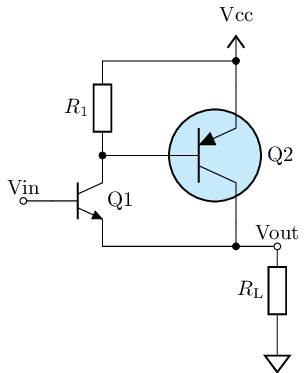

In [83]:
%%tikz -ct

\ctikzset{european resistors, diodes/fill=cyan!20, transistors/arrow pos=end, transistors/fill=cyan!20, amplifiers/fill=cyan!20}
\draw (0, 0) node [above] {Vin}
  to [short, o-] ++(0.5, 0)
  node [npn, anchor=B] (Q1) {Q1};
\draw (Q1.C) to [short, *-] ++(1, 0)
  node [scale=1.5, pnp, tr circle, anchor=B] (Q2) {};
\draw (Q2) node [right=0.4cm] {Q2};
\draw (Q1.C) to [R, l=$R_1$, bipoles/length=1cm] ++(0, 1.6) 
  coordinate (VCC)
  to [short, -*] (VCC -| Q2.E)
  node [vcc] {Vcc}
  -- (Q2.E);
%\draw (Q1.E) % to [short,i>=\li{E}] ++(0, -0.2)
\draw (Q1.E) to [short] (Q1.E-|Q2.C) -- (Q2.C);
\draw (Q1.E-|Q2.C) to [short, *-o] ++(0.7, 0)
  node [above] {Vout}
  to [R, l_=$R_\mathrm{L}$, bipoles/length=1cm] ++(0, -1.5)
  node [sground] {};


Q1 的偏置电流由 Q2 提供（$\ui{C1}\approx\dfrac{\uv{BE2}}{R_1} + \ui{B2}$），因此与 $\uv{BE2}$ 的变化成正比，而不是与输出电流成正比。而 $\uv{BE2}\propto \ln \ui{out}$，即输出电流增大 10 倍，$\uv{BE2}$ 增加 60mV，$\ui{C1}$ 增加大约 $\dfrac{60\mathrm{mV}}{R_1}$，那么 $\Delta \uv{BE1}\approx\ln \Delta \ui{C1}$。
这个过程中对电流取了两次对数。可见这个电路降低了输出阻抗，提高了输出的线性度。

假设 $\beta_2=50$, $R_1=68$Ω，现在 $\ui{C2}=50$mA，$\uv{BE2}=0.7$V，$\ui{C1}=\dfrac{\uv{BE2}}{R_1}+\ui{B2}=\dfrac{0.7}{68}+\dfrac{\ui{C2}}{\beta_2} =11.3$mA；当 $\ui{C2}$ 增加到 500mA，$\uv{BE2}=0.76$V，$\ui{C1}=\dfrac{\uv{BE2}}{R_1}+\ui{B2} = \dfrac{0.76}{68}+\dfrac{\ui{C2}}{\beta_2} = 21.2$mA，则 $\Delta \uv{BE1}\approx 16.4$mV

这比原来的单管 emitter follower $\Delta \uv{BE1}\approx 60$mV 好得多，输出阻抗从 $\dfrac{60}{450}=0.133$Ω 降到了 $\dfrac{16.4}{450}=0.0364$Ω。 

## 电流源 current source

跟 emitter follower 相似的电路，如果我们要的是集电极电流，那就是个电流源。

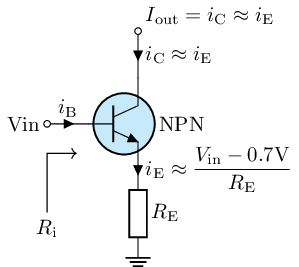

In [7]:
%%tikz -ct -p amsmath
\ctikzset{european resistors, transistors/arrow pos=end, transistors/fill=cyan!20, amplifiers/fill=cyan!20}
\newcommand{\li}[1]{\ensuremath{i_\mathrm{#1}}}
\newcommand{\ui}[1]{{I_\mathrm{#1}}}
\newcommand{\uv}[1]{{V_\mathrm{#1}}}
\newcommand{\sm}[2]{{{#1}_\mathrm{#2}}}

\draw (0, 0) node [left] {Vin}
to [short, o-, i=$\li{B}$] ++(0.7, 0)
node [npn, tr circle, anchor=B] (Q) {NPN};
\draw (Q.C) to [short, -o, i_<={$\li{C}\approx\li{E}$}] ++(0, 0.8)
    node [above right] {$\ui{out}=\li{C}\approx\li{E}$};
\draw (Q.E)
to [R, l=$R_\mathrm{E}$, bipoles/length=1cm] ++(0, -1.5) node [tlground] {};
\draw (Q.E) node [currarrow, rotate=-90] {} node [right] {$\li{E}\approx\dfrac{\uv{in}-0.7\mathrm{V}}{\sm{R}{E}}$};

% \draw [->] (0, -1.5) node [below] {$R_\mathrm{i}$} to ++(0, 1) to ++(0.5, 0);

要定量，用运放。

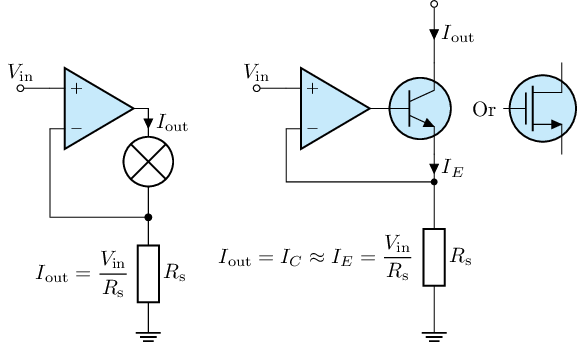

In [25]:
%%tikz -ct -p amsmath

\ctikzset{american currents, american voltages, european resistors}
\ctikzset{diodes/fill=cyan!20, transistors/arrow pos=end, transistors/fill=cyan!20, amplifiers/fill=cyan!20}
\draw (0, 0) node[above]{$V_\mathrm{in}$} to[short, o-] ++(0.5,0)
node[op amp, noinv input up, anchor=+, scale=0.7](opamp){};
\draw (opamp.out) to [lamp, n=LED, i>^=$I_\mathrm{out}$] ++(0, -1.8)
  to [R, l^=$R_\mathrm{s}$, n=R, bipoles/length=1.2cm] ++(0, -2) coordinate (G) node[tlground]{};
\draw (opamp.-) -- ++(0, -1.5) coordinate (INV) to [short, -*] (INV -| LED);
\draw (R) ++(-0.2, 0) node [left] {$I_\mathrm{out} = \dfrac{V_\mathrm{in}}{R_\mathrm{s}}$};

\draw (4, 0) node [above] {{$V_\mathrm{in}$}} to [short,o-]
++(0.5,0) node [op amp, noinv input up, anchor=+, scale=0.7] (opamp) {}
(opamp.out) node [right, npn, tr circle] (Q) {};
\draw (opamp.-) -- ++(0, -0.9) coordinate (INV) -- (INV -| Q.E);
\draw (Q.E) to [short, i=$I_E$] (INV -| Q.E)
  to [R, l^=$R_\mathrm{s}$, *-, n=R, bipoles/length=1.2cm] (Q.E|-G) node[tlground]{};
\draw (Q.C) to [short, -o, i_<=$I_\mathrm{out}$] ++(0,1);
\draw (R)  ++(-2.0, 0) node [open] {$I_\mathrm{out} = I_C \approx I_E =\dfrac{V_\mathrm{in}}{R_\mathrm{s}}$};
\draw (opamp.out) ++(3, 0) node [nmos, arrowmos, tr circle] (NMOS) {};
\draw (NMOS.G) node [left] {Or\ };


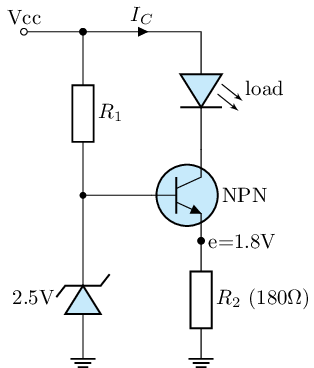

In [12]:
%%tikz -ct
\ctikzset{european resistors, diodes/fill=cyan!20, transistors/arrow pos=end, transistors/fill=cyan!20}
\draw (0, 0) node [above] {Vcc}
    node [ocirc] {}
    to [short, -*] ++(1, 0) coordinate(A)
    to [short,i={$I_C$}]++(2,0)
    to [leD, l={load}] ++(0, -2)
    node [npn, tr circle, anchor=C] (Q1) {NPN};
\draw (A) to [R, -*, l={$R_1$}, bipoles/length=1.2cm] (A|-Q1.B) -- (Q1.B);
\draw (Q1.E) to [R, l={$R_2$ (180$\Omega$)}, bipoles/length=1.2cm] ++(0, -2) coordinate(G2)
  node[tlground]{};
\draw (A|-G2) node[tlground]{} to [zzD, l={2.5V}, bipoles/length=1.2cm] ++(0, 2) -- (A|-Q1.B);
\draw (Q1.E) node [circ] {} node [right] {e=1.8V};

### Current limit

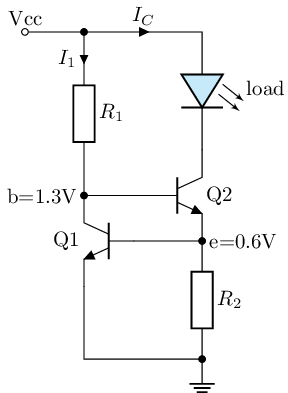

In [13]:
%%tikz -ct
\ctikzset{european resistors, diodes/fill=cyan!20, transistors/arrow pos=end, transistors/fill=cyan!20}
\draw (0, 0) node [above] {Vcc}
    node [ocirc] {}
    to [short, -*] ++(1, 0) coordinate(A)
    to [short,i={$I_C$}]++(2,0)
    to [leD, l={load}] ++(0, -2)
    node [npn, anchor=C] (Q1) {Q2};
\draw (A) to [R, -*, l={$R_1$}, i>_={$I_1$}, bipoles/length=1.2cm] (A|-Q1.B) coordinate (B) -- (Q1.B);
\draw (B) node[npn, anchor=C, xscale=-1] (Q2) {\ctikzflipx{Q1}};
\draw (Q2.B) -- (Q1.E) to [R, l={$R_2$}, bipoles/length=1.2cm] ++(0, -2) coordinate(G) node[ground]{};
%\draw (A|-G2) node[ground]{} to [zzD, l={2.5V}] ++(0, 2) -- (A|-Q1.B);
\draw (Q2.E) -- (Q2.E|-G) to [short, -*] (G);
\draw (Q1.E) node [circ] {} node [right] {e=0.6V};
\draw (Q2.C) node [circ] {} node [left] {b=1.3V};

ERROR:ngspyce.sharedspice:Note: v1: dc value used for op instead of transient time=0 value.
ERROR:ngspyce.sharedspice:Note: v1: dc value used for op instead of transient time=0 value.


         b =   1.3588 V
         c =   3.9315 V
         e =   0.6013 V
 v1#branch =  -10.762 mA
       vin =   5.0000 V
range 12.01 mA


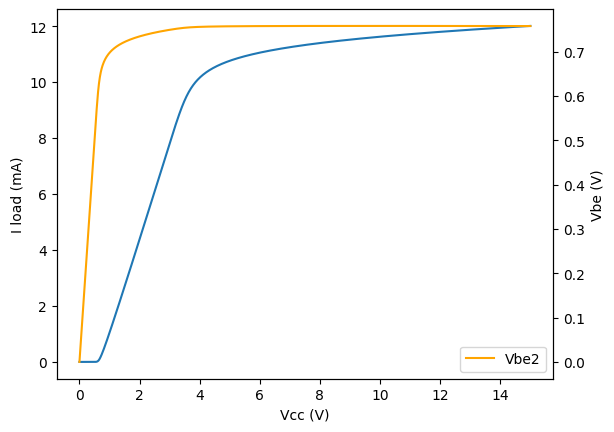

In [41]:
ng.circ("""
  V1 Vin 0 dc 5 pulse(0 15 0 1 1)
  R1 Vin b 47k
  Q1 c b e NPN
  R2 e 0 56
  Q2 b e 0 NPN
  Rload Vin c 100
  .model NPN NPN(IS=2fA BF=200 VAF=130)
  """)
print_op()
ng.cmd('tran 1m 1')
Vb = ng.vectors()['b']
Ve = ng.vectors()['e']
Vin2 = ng.vectors()['vin']
Iload2 = -1000 * ng.vectors()['v1#branch']
fig, ax = plt.subplots()
plt.plot(Vin2, Iload2)
plt.xlabel("Vcc (V)")
plt.ylabel("I load (mA)")
print('range %.2f mA' % (Iload2[-1] - Iload2[0]))
ax2 = ax.twinx()
Vbe2 = Vb - Ve
# plt.plot(Vin2, Ve, 'orange', label='Vbe1')
plt.plot(Vin2, Vbe, 'orange', label='Vbe2')
plt.ylabel('Vbe (V)')
plt.legend()

range 12.01 mA


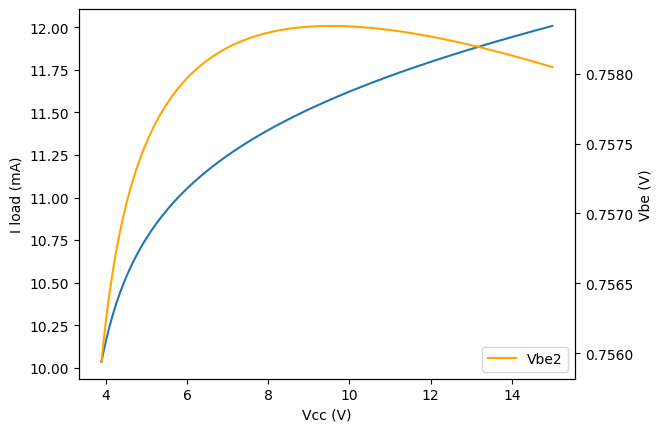

In [42]:
fig, ax = plt.subplots()
start=int(4/15*1000)
plt.plot(Vin2[start:], Iload2[start:])
plt.xlabel("Vcc (V)")
plt.ylabel("I load (mA)")
print('range %.2f mA' % (Iload2[-1] - Iload2[0]))
ax2 = ax.twinx()
plt.plot(Vin2[start:], Vbe2[start:], 'orange', label='Vbe2')
plt.ylabel('Vbe (V)')
plt.legend(loc='lower right')

Drive Zener diode

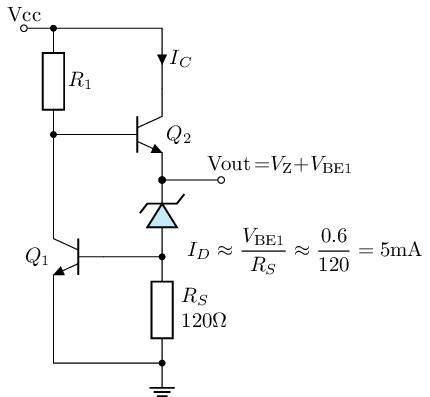

In [2]:
%%tikz -ct -p amsmath

\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}
\ctikzset{diodes/fill=cyan!20, transistors/arrow pos=end, transistors/fill=cyan!20, european resistors}
\draw (0, 0) node [above] {Vcc}
    to [short, o-] ++(0.5, 0) coordinate(A)
    to [R, *-*, l={$R_1$}, bipoles/length=1.2cm] ++(0, -1.8) coordinate (B)
    to [short] ++(1.0, 0)
    node [npn, anchor=B] (Q1) {$Q_2$};
\draw (A) to [short] (A-|Q1.C) to [short,i={$I_C$}] (Q1.C);
\draw (Q1.E) to [short, *-o] ++(1, 0) ++(1,0) node [above] {Vout\,=\uv{Z}+\uv{BE1}};
\draw (Q1.E)
    to [zzD, invert, mirror, bipoles/length=1cm] ++(0, -1.2) coordinate (D);
\draw (B) to [short] ++(0, -1.3) node[npn, anchor=C, xscale=-1] (Q2) {};
\draw (Q2) node[left=-2pt] {$Q_1$};
\draw (Q2.B) -| (D);
\draw (Q2.B -| Q1.E) to [R, l2={$R_S$ and $120\Omega$}, *-*, bipoles/length=1.2cm] ++(0, -1.8) coordinate(G) node[ground]{};
\draw (Q2.E) |- (G);
\draw (D)++(0.3, 0) node [right] {$I_D \approx\dfrac{\uv{BE1}}{R_S}\approx \dfrac{0.6}{120}=5$mA};

### 4-to-20 mA

https://electronics.stackexchange.com/questions/712043/how-can-i-create-4-20-ma-current-souce/712079#712079

Gounded load.

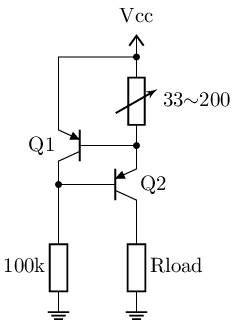

In [28]:
%%tikz -ct
\ctikzset{european resistors, transistors/arrow pos=end, bipoles/length=1.2cm}
\draw (0, 0) node [pnp] (Q2) {Q2};
\draw (Q2.E) to [short, *-] ++(-0.6, 0)
  node [pnp, anchor=B, xscale=-1] (Q1) {\ctikzflipx{Q1}};
\draw (Q2.E) to [vR, mirror, bipoles/length=1cm, l_={33$\sim$200}] ++(0, 1.5)
  node [circ] {}  coordinate (T) -| (Q1.E);
\draw (T) node [vcc] {Vcc};
\draw (Q2.B) to [short, -*] (Q1.C);
\draw (Q2.C)
  to [R, bipoles/length=1cm, l={Rload}] ++(0, -1.5)
  node [tlground] {}  coordinate (G);
\draw (G-|Q1.C) node [tlground] {}
  to [R, bipoles/length=1cm, l={100k}] ++(0, 1.5)
  -- (Q1.C);

### Vbe 抵消

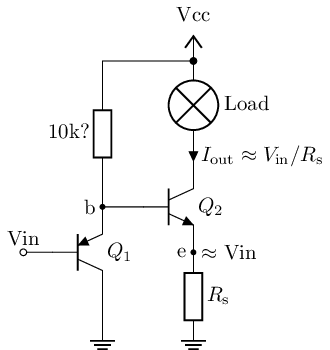

In [13]:
%%tikz -ct

\ctikzset{european resistors, diodes/fill=blue!20, transistors/arrow pos=end, transistors/fill=cyan!20}
\draw (0, 0) node [above] {Vin}
  to [short, o-] ++(0.5, 0)
  node [pnp, anchor=B] (Q1) {$Q_1$};
\draw (Q1.E) node [left] {b} to [short] ++(0.7, 0)
  node [npn, anchor=B] (Q2) {$Q_2$};
\draw (Q2.C) to [short, i_<=$I_\mathrm{out}\approx V_\mathrm{in}/R_\mathrm{s}$] ++(0, 0.2)
  to [lamp, l_=Load] ++(0, 1.5) coordinate (VCC)
  node [vcc] {Vcc};
\draw (Q1.E) to [R, l=10k?, *-, bipoles/length=1cm] (Q1.E|-VCC)
  to [short, -*] (VCC);
\draw (Q2.E) node [left] {e} node [right] {$\approx $ Vin}
  to [R, l=$R_\mathrm{s}$, *-, bipoles/length=1cm] ++(0, -1.5) coordinate (G)
  node [tlground] {};
\draw (Q1.C) to [short] (Q1.C|-G) node [tlground] {};

### Current mirror

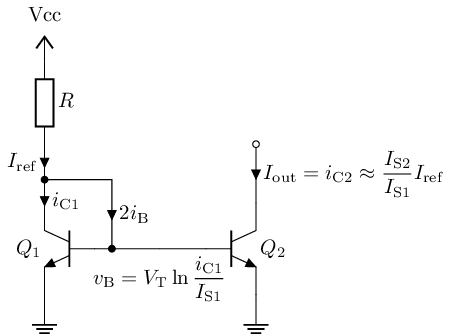

In [27]:
%%tikz -ct -p amsmath

\ctikzset{american currents, american voltages, european resistors}
\ctikzset{diodes/fill=cyan!20, transistors/arrow pos=end, transistors/fill=cyan!20, amplifiers/fill=cyan!20}
%\ctikzset{bipoles/length=1cm};
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}
\newcommand{\li}[1]{\ensuremath{i_\mathrm{#1}}}
\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}
\newcommand{\lv}[1]{\ensuremath{v_\mathrm{#1}}}

\draw (0, 0) node [npn, xscale=-1] (Q) {};
\draw (Q) node [left=-2pt] {$Q_1$};
\draw (Q.C) to [short, i_<=\li{C1}] ++(0, 0.1)
  to [short, -*] ++(0, 0.3) coordinate (A);
\draw (Q.B) to [short] ++(0.3, 0) coordinate (B);
\draw (A) -- (A-|B) to [short, i={$2\li{B}$}] (B);
\draw (Q.E) to [short, %i={$\li{E1}=\ui{S1}\exp\dfrac{\lv{B}}{\uv{T}}$},
n=E] ++(0, -0.1)
  node [ground] {} coordinate (K);
%\draw (A)++(0.3, 0.3) node [right] {$\lv{B} = f(\ui{ref})$};

\draw (A) to [short, i<=\ui{ref}] ++(0, 0.6)
  to [R, l_=$R$,bipoles/length=1cm] ++(0, 1.4)
  node [vcc] {Vcc};
\draw (B) to [short, *-] ++(0.8, 0) coordinate (VO)
  node [below] {$\lv{B}=\uv{T}\ln\dfrac{\li{C1}}{\ui{S1}}$};
\draw (VO) to [short] ++(0.8, 0) coordinate (B);
\draw (B) node [npn, anchor=B] (Q2) {$Q_2$};
\draw (Q2.E) to [short, % i={$\li{E2}=\ui{S2}\exp\dfrac{\lv{B}}{\uv{T}}$},
n=E] ++(0, -0.1)
  node [ground] {} coordinate (K);
\draw (Q2.C) to [short, -o, i_<={$\ui{out}=\li{C2}\approx\dfrac{\ui{S2}}{\ui{S1}}\ui{ref}$}] ++(0, 1);


### 比例电流源

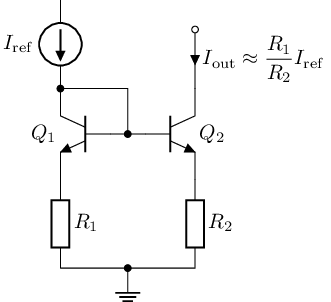

In [17]:
%%tikz -ct -p amsmath

\ctikzset{american currents, american voltages, european resistors}
\ctikzset{transistors/arrow pos=end}
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}
    
\draw (0, 0) node [npn, xscale=-1] (Q1) {\ctikzflipx{$Q_1$}};

\draw (Q1.B) to [short] ++(0.6, 0)
  node [npn, anchor=B] (Q2) {$Q_2$};
\draw (Q1.B) ++(0.3, 0) coordinate (M) node [circ] {} |- (Q1.C);
\draw (Q1.C) node [circ] {}
  to [I, invert, l={\ui{ref}}, bipoles/length=1.2cm] ++(0, 1.5);
\draw (Q1.E) to [R, l={$R_1$}, bipoles/length=1.0cm] ++(0, -1.5)
  coordinate (G);
\draw (Q2.E) to [R, l={$R_2$}, bipoles/length=1.0cm] (Q2.E |- G) -- (G);
\draw (G -| M) node [circ] {} node [ground] {};
\draw (Q2.C) to [short, -o, i_<={$\ui{out}\approx\dfrac{{R_1}}{{R_2}}\ui{ref}$}] ++(0, 1);

### 电压电流转换 4-to-20 mA 

https://electronics.stackexchange.com/questions/712043/how-can-i-create-4-20-ma-current-souce/712079#712079

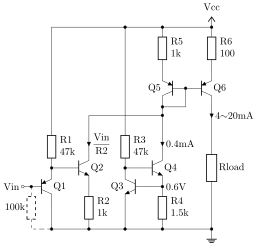

In [29]:
%%tikz -ct -f svg
\ctikzset{european resistors, transistors/arrow pos=end, bipoles/length=1.2cm}

\draw (0, 0) node [npn] (Q4) {Q4};
\draw (Q4.E) to [R, l2={R4 and 1.5k}, bipoles/length=1cm] ++(0, -1.5) node [circ] {} coordinate (G);
\draw (Q4.E) to [short, *-] ++(-0.6, 0) node [npn, anchor=B, xscale=-1] (Q3) {\ctikzflipx{Q3}};
%\draw (Q3.E) |- (G) node [circ] {} node [sground] {};
\draw (Q3.E) to [short, -*] (Q3.E |- G);
\draw (Q4.B) to [short, -*] (Q3.C);
\draw (Q3.C) to [R, l2_={R3 and 47k}, bipoles/length=1cm] ++(0, 1.5) coordinate (R5);
\draw (Q4.C) ++(0, 0.2) node [currarrow, rotate=-90] {} node [right] {0.4mA};
\draw (Q4.E) node [right] {0.6V};

\draw (Q4.C) to [short, -*] ++(0, 1.5)
  node [pnp, anchor=C, xscale=-1] (Q5) {\ctikzflipx{Q5}};
\draw (Q5.B) to [short, -*] ++(0.1, 0) |- (Q5.C);
\draw (Q5.B)++(0.1, 0) to [short] ++(0.2, 0) node [pnp, anchor=B] (Q6) {Q6};
\draw (Q5.E)  to [R, l2_={R5 and 1k}, bipoles/length=1cm] ++(0, 1.5) node [circ] {} coordinate (T);
\draw (Q6.E)  to [R, l2_={R6 and 100}, bipoles/length=1cm] ++(0, 1.5) node [circ] {} node [vcc] {Vcc} -- (T);
\draw (R5) to [short, -*] (R5 |- T);

\draw (Q5.C) ++(0, -0.3) to [short, *-] ++(-2.6, 0) coordinate (Q2c);
\draw (Q2c |- Q4) node [npn] (Q2) {Q2};
\draw (Q2.E) to [R, l2={R2 and 1k}, bipoles/length=1cm] (Q2.E |- G) node [circ] {};
\draw (Q2.B) to [short, -*] ++(-0.6, 0) node [pnp, anchor=E] (Q1) {Q1};
\draw (Q1.B) to [short, *-o] ++(-0.3, 0) node [left] {Vin};
\draw (Q1.C) to [short, -*] (Q1.C |- G);
\draw (Q1.E) to [R, l2_={R1 and 47k}, bipoles/length=1cm] ++(0, 1.5) |- (T);
\draw (Q2c) to [short] (Q2.C);
\draw (Q2.C) ++(0, 0.2) node [currarrow, rotate=-90] {} node [right] {$\displaystyle\frac{\mathrm{Vin}}{\mathrm{R2}}$};
\draw [dashed] (Q1.B) to [R, l_={100k}, bipoles/length=1cm] (Q1.B |- G) to [short] (Q1.C |- G);

\draw (Q6.C) to [R, l={Rload}] (Q6.C |- G) node [circ] {} node [ground] {} --(Q1.C |- G);
\draw (Q6.C) ++(0, -0.3) node [currarrow, rotate=-90] {}  node [right] {4$\sim$20mA};

* Q1/Q2 是 Vbe 抵消型电流源，产生正比于 Vin 的电流
* Q3/Q4 是以 $\uv{BE3}$ 为基准的固定电流源，产生 0.4mA 电流
* Q5/Q6 是比例电流源，将前面两个电流相加之后再放大 10 倍，产生输出电流

校准：
1. 先将 Vin 接地，调节 R3 使输出为 4mA
2. 将 Vin 设为最大值，调节 R2 使输出为 20mA

### Widlar 微电流源

$ \ui{C2}\approx\ui{E2}$

$\uv{R1} = \ui{C2}R_1 = \uv{T}\ln \dfrac{\ui{C1}}{\ui{C2}}$

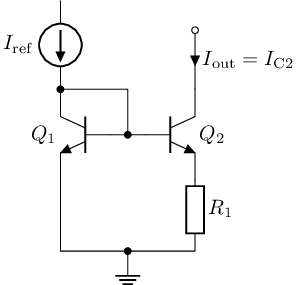

In [8]:
%%tikz -ct -p amsmath

\ctikzset{american currents, american voltages, european resistors}
\ctikzset{transistors/arrow pos=end}
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}
\newcommand{\li}[1]{\ensuremath{i_\mathrm{#1}}}
    
\draw (0, 0) node [npn, xscale=-1] (Q1) {\ctikzflipx{$Q_1$}};

\draw (Q1.B) to [short] ++(0.6, 0)
  node [npn, anchor=B] (Q2) {$Q_2$};
\draw (Q1.B) ++(0.3, 0) coordinate (M) node [circ] {} |- (Q1.C);
\draw (Q1.C) node [circ] {}
  to [I, invert, l={\ui{ref}}, bipoles/length=1.2cm] ++(0, 1.5);
\draw (Q2.E) to [R, l={$R_1$}, bipoles/length=1.0cm] ++(0, -1.0)
  to [short] ++(0, -0.2) coordinate (G);
\draw (Q1.E) to  (Q1.E |- G) -- (G);
\draw (G -| M) node [circ] {} node [ground] {};
\draw (Q2.C) to [short, -o, i_<={$\ui{out}=\ui{C2}$}] ++(0, 1);

In [3]:
Ic1 = 1e-3  # 1mA
Ic2 = 1e-5  # 10μA
Vt = 25.865e-3
R1 = Vt * log(Ic1 / Ic2) / Ic2
print('R1 = %.2f kΩ' % (R1 / 1e3))

R1 = 11.91 kΩ


In [16]:
import scipy
def Ic2(x):
    Ic = x
    Vt = 25.865
    Iref = 1000  # μA
    R = 5  # kΩ
    return Ic * R - Vt * np.log(Iref / Ic)

root = scipy.optimize.root_scalar(Ic2, x0=0.1)
if root.converged:
    Ic = root.root
    print('Iout = %.2f uA' % (Ic))

Iout = 20.19 uA


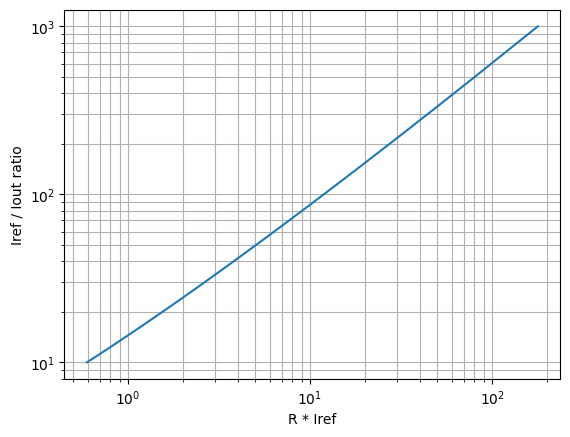

In [8]:
Ic2 = np.arange(1, 101) / 1e6
R1 = Vt * np.log(Ic1 / Ic2) / Ic2
plt.loglog(R1*Ic1, Ic1/Ic2)
plt.ylabel('Iref / Iout ratio')
plt.xlabel('R * Iref')
plt.grid(which='both')

Iref = 1mA

R = 5k

R * Iref = 5

Iref / Iout = 50

Iout = 20uA

## Phase splitter

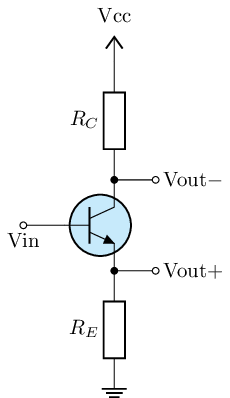

In [45]:
%%tikz -ct
\ctikzset{european resistors, diodes/fill=cyan!20, transistors/arrow pos=end, transistors/fill=cyan!20}
\draw (0, 0) node [npn, tr circle] (Q) {};
\draw (Q.C) to [R, l={$R_C$}, bipoles/length=1.2cm] ++(0, 2) node [vcc] {Vcc};
\draw (Q.C) to [short, *-o] ++ (0.7, 0) node [right] {Vout$-$};
\draw (Q.B) to [short, -o] ++ (-0.7, 0)  node[below]{Vin};
\draw (Q.E) to [R, l_={$R_E$}, bipoles/length=1.2cm] ++(0, -2) node[tlground]{}; 
\draw (Q.E) to [short, *-o] ++ (0.7, 0) node [right] {Vout+};

         b =   5.0000 V
         c =  10.7534 V
         e =   4.2670 V
       vcc =  15.0000 V
vcc#branch =   -4.247 mA
vin#branch =  -20.333 uA


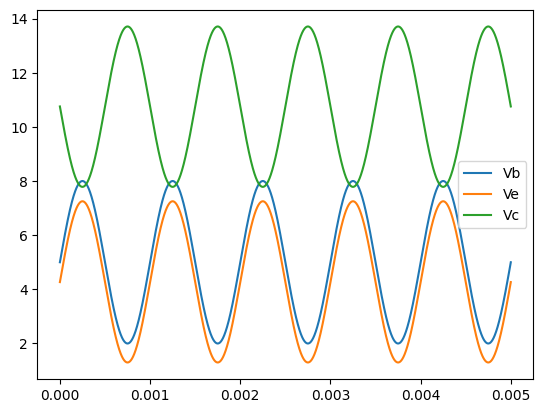

In [48]:
ng.circ("""
  Vcc Vcc 0 15V
  Q1 c b e npn
  Rc Vcc c 1k
  Re e 0 1k
  Vin b 0 DC 5 SINE(5 3 1k)
  .model npn npn(IS=2fA BF=200 VAF=130)
  """)
print_op()
ng.cmd('tran 1u 5m')
Vb = ng.vector('b')
Vc = ng.vector('c')
Ve = ng.vector('e')
time = ng.vector('time')
plt.plot(time, Vb, label='Vb')
plt.plot(time, Ve, label='Ve')
plt.plot(time, Vc, label='Vc')
plt.legend()

### Common-emitter amplifiler with emitter degeneration

## Osc